<a href="https://colab.research.google.com/github/patyDSantos/baoba_project/blob/main/COLAB__Baoba_relatorio_geral_1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title #1. Importa as bibliotecas necessárias {display-mode: "form"}

# Importa as bibliotecas necessárias para manipulação de dados e criação de gráficos.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, clear_output
import os
from datetime import datetime

# Importa o módulo 'drive' do Google Colab, que permite interagir com o Google Drive.
from google.colab import drive

# Carrega a extensão do Colab para uma exibição dos DataFrames e habilita o formatador.
%load_ext google.colab.data_table
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Clona o repositório do projeto Baoba do GitHub e navega até o diretório clonado.
!git clone https://github.com/patyDSantos/baoba_project.git
%cd /content/baoba_project

Cloning into 'baoba_project'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 83 (delta 44), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 1.57 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/baoba_project


In [2]:
# @title #2. Conecta e monta o seu Google Drive {display-mode: "form"}

# Monta o Google Drive no diretório '/content/drive', facilitando o acesso aos arquivos armazenados.
drive.mount('/content/drive')


Mounted at /content/drive


Depois de autorizar, seus arquivos aparecem em
/content/drive/MyDrive/… (seu Drive particular) ou
/content/drive/Shared drives/… (Drives compartilhados).

In [3]:
# @title #3. Cria a estrutura de pastas e definir variáveis de caminho e nomes de arquivo {display-mode: "form"}

#Caminho dos arquivos contendo as bases a serem comparadas
caminho_arquivo = '/content/drive/Shareddrives/arquivo_baoba/abril_2025/primeiro_periodo/'

# Nome dos arquivo
nome_arquivo_atual = 'base.csv'

#Caminho da pasta para salvar os gráficos
caminho_salvar_grafico = '//content/drive/Shareddrives/arquivo_baoba/abril_2025/primeiro_periodo/graficos/'

#Caminho da pasta para salvar .csv que será utilizado para o gráfico comparativo
caminho_salvar_arquivo_comparativo = '/content/drive/Shareddrives/arquivo_baoba/sumario_interacoes/'

In [4]:
# @title Cria o dataframe {display-mode: "form"}

#Cria os dataframes a partir dos arquivos CSV
df    = pd.read_csv(caminho_arquivo + nome_arquivo_atual)
output_folder = caminho_salvar_grafico

# Importa a classe MetricsProcessor do script auxiliar para análise de dados.
from baoba_processamento_dados_geral import ProcessamentoMetricas

# Extração dos monitoramentos da coluna 'monitoramento_nome.keyword'
monitoramentos = df['monitoramento_nome.keyword'].unique().tolist()

#Instância passando os argumentos necessários
analisador = ProcessamentoMetricas(df, monitoramentos)

# Exibe um resumo do DataFrame, mostrando o número de registros, colunas, tipos de dados e uso de memória.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190089 entries, 0 to 190088
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   data                              190089 non-null  object 
 1   monitoramento_nome.keyword        190089 non-null  object 
 2   servico.keyword                   190089 non-null  object 
 3   publicador_nome.keyword           190089 non-null  object 
 4   titulo                            5326 non-null    object 
 5   conteudo.keyword                  188230 non-null  object 
 6   link.keyword                      190089 non-null  object 
 7   manifestacoes_quantidade          190089 non-null  int64  
 8   manifestacoes_detalhadas.keyword  189194 non-null  object 
 9   query                             132330 non-null  object 
 10  interacoes                        189194 non-null  float64
dtypes: float64(1), int64(1), object(9)
memory usage: 16.

In [5]:
# @title #4. Calcula as interações e ocorrências por serviço e monitoramento {display-mode: "form"}

# Atualizar o nome dos monitoramentos
df['monitoramento_nome.keyword'] = df['monitoramento_nome.keyword'].replace({
    'Igualdade Racial ': 'Igualdade Racial',
    'Acessibilidade e inclusão PCD': 'Acessibilidade e Inclusão PCD',
    'Patrimônio público e probidade administr': 'Patrimônio Público e Probidade Administrativa',
    'Proteção e Inclusão Vulneraveis: ': 'Proteção e Inclusão Vulneráveis',
    'Combate à violência contra a mulher': 'Combate à Violência Contra a Mulher',
    'Desinformação em Políticas Públicas': 'Políticas Públicas'
})

# Calcula Interações para cada serviço utilizando o nome padrão da coluna "servico.keyword"
df_face    = analisador.calcula_interacoes(
    df,
    'Facebook - Posts Públicos',
    ['reactions', 'shares', 'comments'],
    service_col='servico.keyword'  # Pode ser omitido se for "servico.keyword"
)

df_x       = analisador.calcula_interacoes(
    df,
    'X',
    ['favorites', 'replies', 'retweets'],
    service_col='servico.keyword'
)

df_insta   = analisador.calcula_interacoes(
    df,
    'Instagram - Posts Públicos',
    ['likes', 'comments'],
    service_col='servico.keyword'
)

df_youtube = analisador.calcula_interacoes(
    df,
    'YouTube - Vídeos',
    ['likes', 'comments', 'views'],
    service_col='servico.keyword'
)

#Unifica todos os dataframes em um
df_unificado = pd.concat([df_face, df_insta, df_x, df_youtube], ignore_index=True)


# ------------------------------------------------------------------
# 1. ===== CRIA ARQUIVO PARA TABELA COMPARATIVA =====
# ------------------------------------------------------------------

df_csv = df_unificado.copy(deep=True)

df_csv['data'] = pd.to_datetime(df_csv['data'])

data_min = df_csv['data'].min().strftime('%d-%m-%Y')   # 04-04-2025
data_max = df_csv['data'].max().strftime('%d-%m-%Y')   # 11-04-2025

df_sumario_csv = (
    df_csv
      .groupby('monitoramento_nome.keyword', as_index=False)
      .agg(
          total_ocorrencias=('monitoramento_nome.keyword', 'count'),
          total_interacoes=('interacoes', 'sum')
      )
)

os.makedirs(caminho_salvar_arquivo_comparativo, exist_ok=True)

nome_arquivo = f'tabela_int_ocorr_{data_min}_{data_max}.csv'
caminho_completo = os.path.join(caminho_salvar_arquivo_comparativo, nome_arquivo)

df_sumario_csv.to_csv(caminho_completo, index=False, encoding='utf-8-sig')



##5. Cria e exibe os gráficos

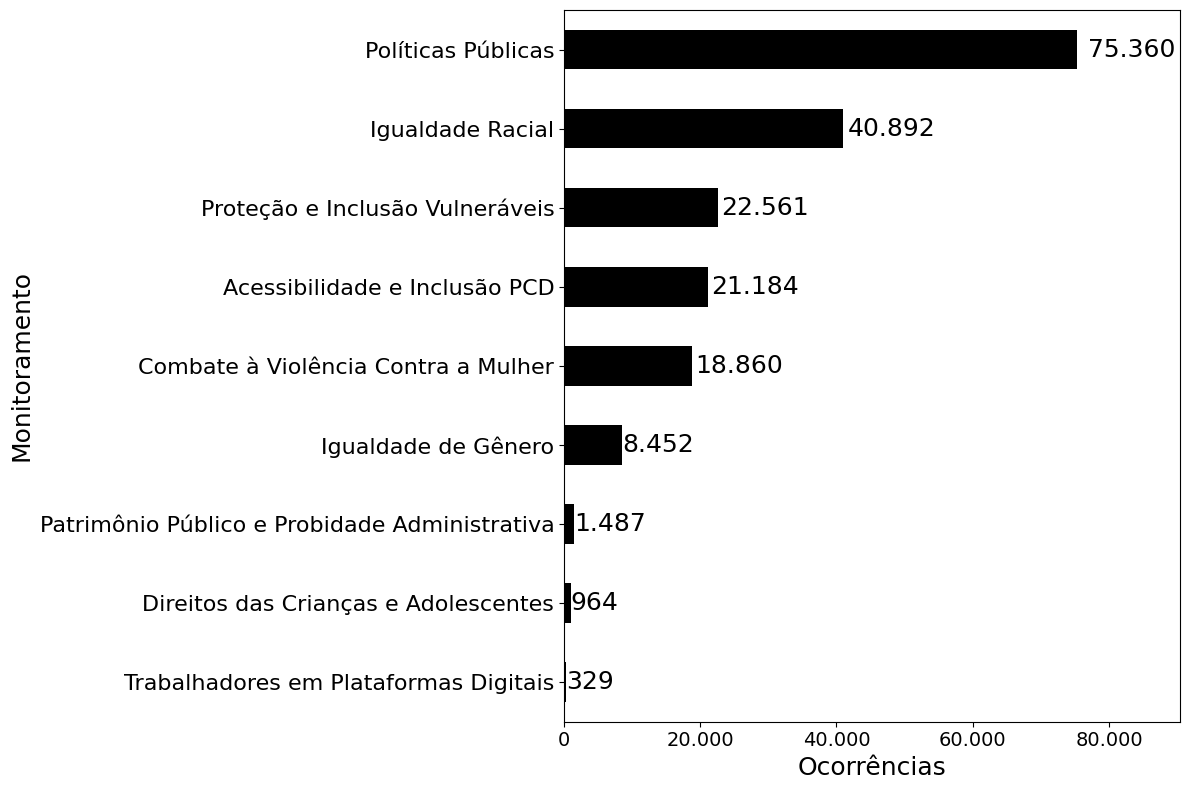

In [6]:
# @title Gráfico de ocorrências por monitoramento {display-mode: "form"}

analisador.plota_grafico_ocorrencias_df(
    df_unificado,
    'monitoramento_nome.keyword', # Nome da coluna para agrupar os dados
    title='', # Título do gráfico
    colors='black', # Cor das barras
    log_scale=False, # Escala logarítmica no eixo X
    figsize=(12,8), # Tamanho da figura (valor sugerido, pode ser ajustado)
    fontsize=18,  # Definindo o tamanho da fonte (valor sugerido, pode ser ajustado)
    save_path=output_folder + 'grafico_geral_ocorrencias_monitoramento.png'
)

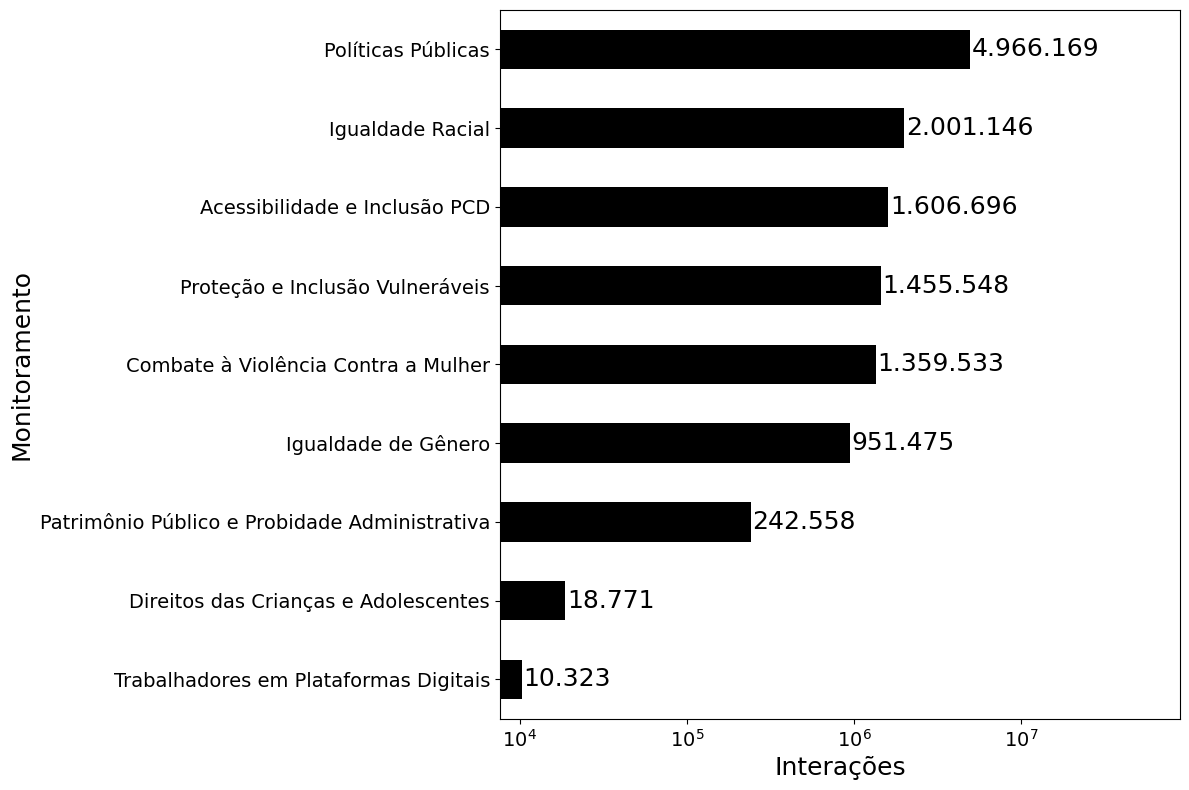

In [7]:
# @title Gráfico de interações por monitoramento {display-mode: "form"}
analisador.plota_grafico_interacoes(
    df_unificado,
    monitoramento_col='monitoramento_nome.keyword',  # Nome da coluna para agrupar os dados
    interacoes_col='interacoes',                        # Coluna com os valores a serem somados
    title='',        # Título do gráfico
    colors='black',                                     # Cor das barras
    log_scale=True,                                     # Escala logarítmica no eixo X
    figsize=(12,8),                                     # Tamanho da figura (valor sugerido, pode ser ajustado)
    fontsize=18,  # Definindo o tamanho da fonte (valor sugerido, pode ser ajustado)
    save_path=output_folder + 'grafico_geral_interacoes_monitoramento.png'
)

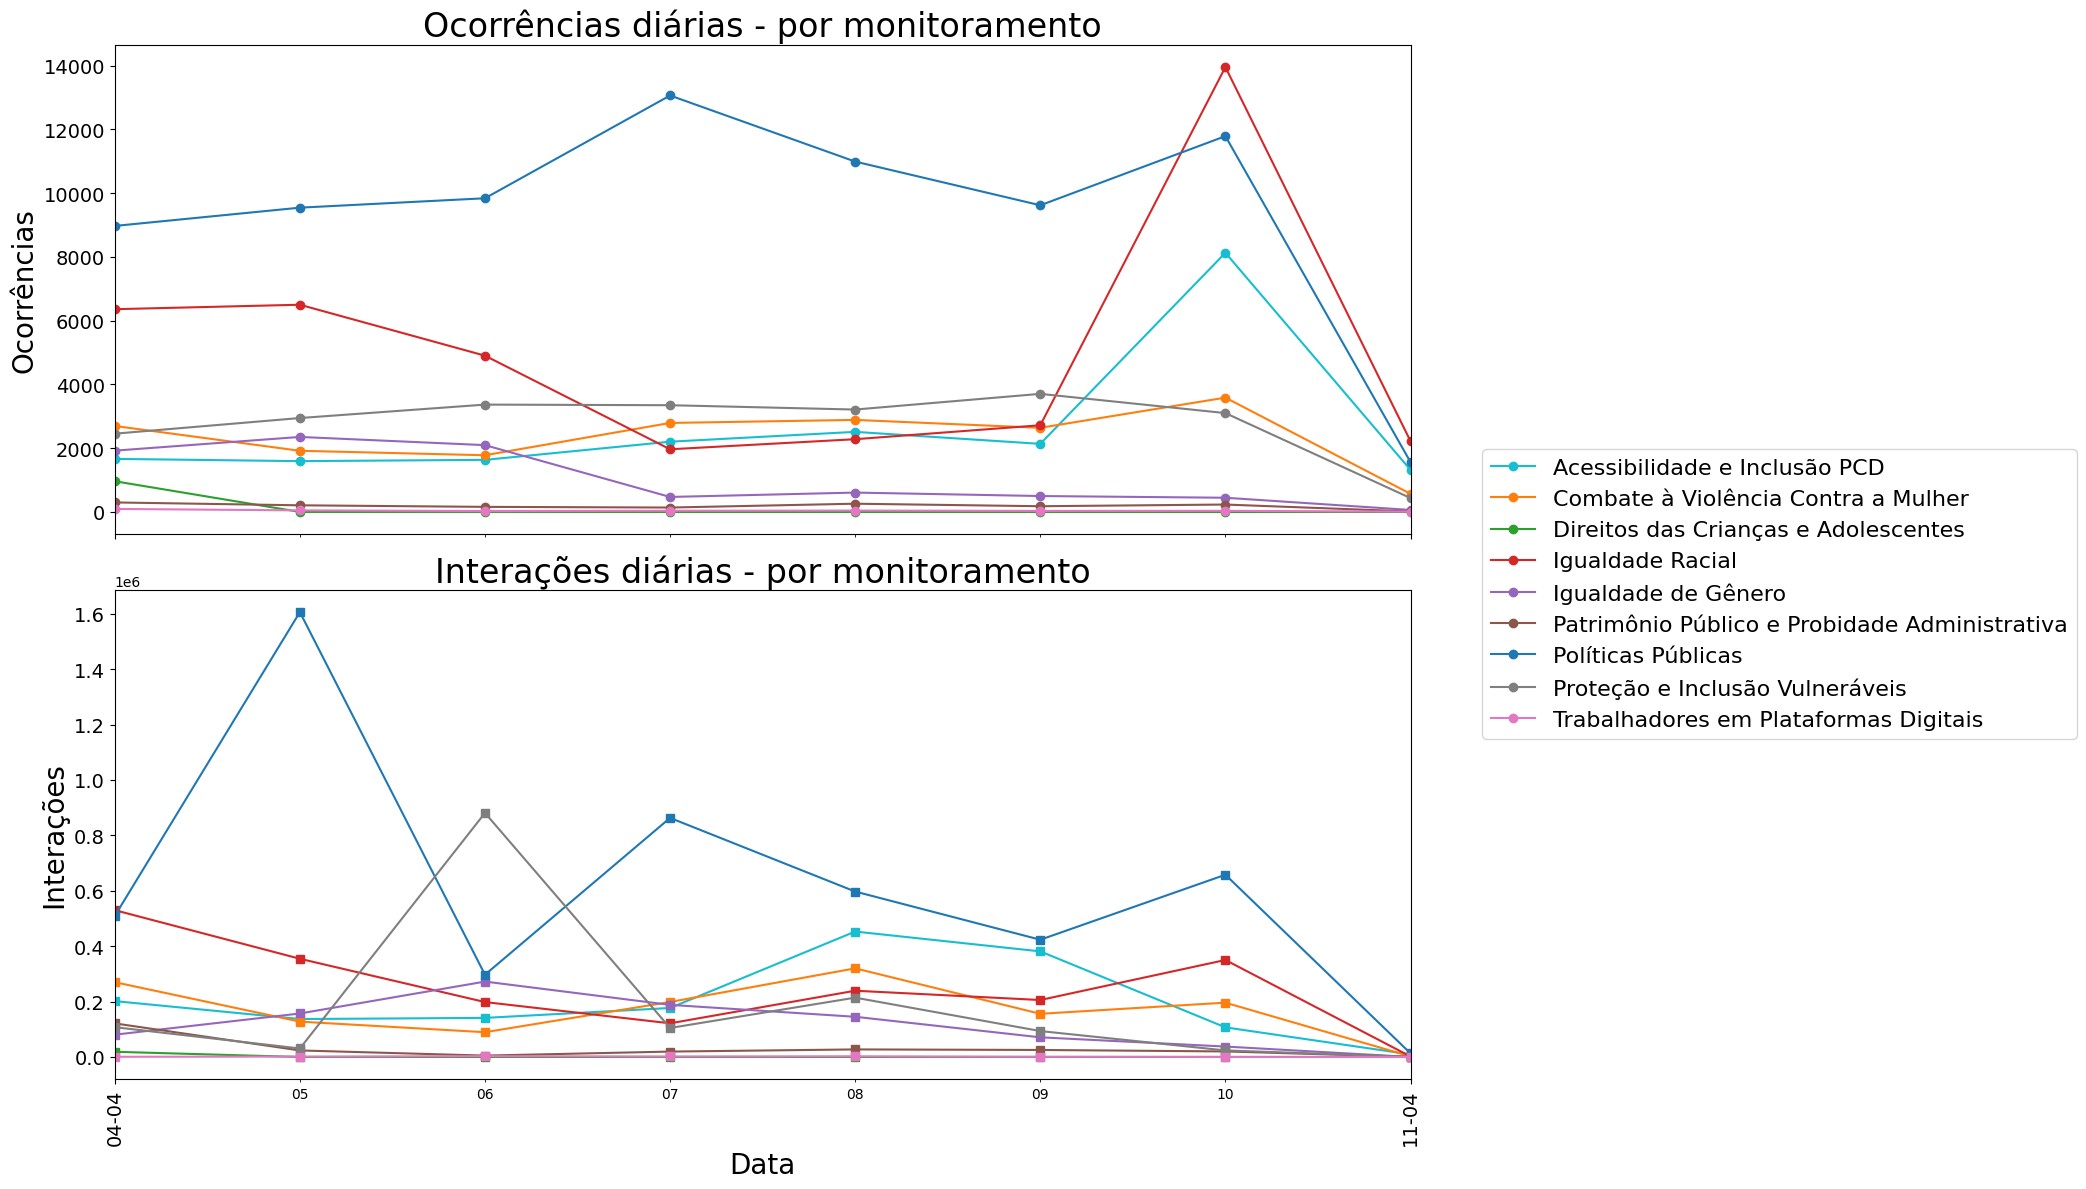

In [8]:
# @title Gráfico de ocorrências e interações diárias por monitoramento (linhas) {display-mode: "form"}
analisador.plota_grid_graficos_interacoes_e_ocorrencias_estilo_linha(
    df=df_unificado,
    top_title="por monitoramento",
    date_col="data",
    monitoramento_col="monitoramento_nome.keyword",
    ocorrencia_col="conteudo.keyword",
    interacoes_col="interacoes",
    figsize=(18, 12),
    title_fontsize=24,
    label_fontsize=20,
    legend_fontsize=16,
    tick_labelsize=14
)

In [9]:
# @title Gráfico de ocorrências e interações diárias por monitoramento (área) - passe o mouse sobre o gráfico para ver o picos {display-mode: "form"}
analisador.plota_grid_graficos_interacoes_e_ocorrencias_area_interativo(
    df=df_unificado,
    top_title="Gráfico",
    date_col="data",
    monitoramento_col="monitoramento_nome.keyword",
    ocorrencia_col="conteudo.keyword",
    interacoes_col="interacoes"
)

#6. Cria uma tabela dinâmica com os top n posts com mais interações a partir da escolha do monitoramento por um dropdrown

A tabela exibe um máximo de 20 mil linhas. Você pode selecionar a quantidade de linhas da tabela  na variável quantidade_linhas



```
quantidade_linhas = 1000
```



#✍Preencha a quantidade de linhas desejadas na célula abaixo

In [10]:
#preencha a quantidade máxima de linhas que gostaria de visualizar aqui. Valores entre 1 e 20000
quantidade_linhas = 5

In [11]:
# @title Tabela Dinâmica - selecione o monitoramento no dropdrown{display-mode: "form"}

# This code will be hidden when the notebook is loaded.
# Selecionando as colunas de índice 0 a 6, mais 9 e 14 - isso remove as colunas desnecessárias para a análise
colunas_escolhidas = ['data',
 'monitoramento_nome.keyword',
 'servico.keyword',
 'publicador_nome.keyword',
 'titulo',
 'conteudo.keyword',
 'link.keyword',
  'query',
 'interacoes',
]

df_unificado_resumido = df_unificado[colunas_escolhidas]

# Cria rótulos no formato dia-mês para exibição no eixo X
df_unificado_resumido.loc[:, 'data'] = pd.to_datetime(df_unificado_resumido['data']).dt.strftime('%d-%m-%Y')

# Cria o dropdown usando os valores únicos da coluna
options = df_unificado_resumido["monitoramento_nome.keyword"].unique().tolist()
dropdown_monitoramento = widgets.Dropdown(
    options=options,
    description="Monitoramento"
)

# Cria um Output para exibir os resultados
out = widgets.Output()

def atualiza_display(change):
    if change["type"] == "change" and change["name"] == "value":
        with out:
            clear_output()  # Limpa o output anterior
            monitoramento_valor = change["new"]

            # Filtra o DataFrame com base no valor do dropdown
            df_filtrado = df_unificado_resumido[
                df_unificado_resumido["monitoramento_nome.keyword"] == monitoramento_valor
            ]

            df_filtrado_sorted = df_filtrado.sort_values(
                by="interacoes", ascending=False
            )

            # Exibe as primeiras linhas do DataFrame filtrado
            display(df_filtrado_sorted.head(quantidade_linhas))

# Liga o callback ao dropdown
dropdown_monitoramento.observe(atualiza_display, names="value")

# Exibe o widget e a área de output
display(dropdown_monitoramento)
display(out)

Dropdown(description='Monitoramento', options=('Políticas Públicas', 'Proteção e Inclusão Vulneráveis', 'Comba…

Output()